In [1]:
import librosa
import numpy as np

class ZScoreNormaliser:
    """ZScoreNormaliser applies z-score normalization to an array."""

    def normalise(self, array, mean, std):
        norm_array = (array - mean) / std
        return norm_array

    def denormalise(self, norm_array, mean, std):
        array = norm_array * std + mean
        return array


class SoundGenerator:
    """SoundGenerator is responsible for generating audios from
    spectrograms using a trained VAE model.
    """

    def __init__(self, vae, hop_length, global_mean, global_std):
        self.vae = vae
        self.hop_length = hop_length
        self.global_mean = global_mean
        self.global_std = global_std
        self._normaliser = ZScoreNormaliser()

    def generate(self, spectrograms):
        # Generate reconstructed spectrograms and latent representations from the VAE
        generated_spectrograms, latent_representations = self.vae.reconstruct(spectrograms)
        # Convert spectrograms back to audio signals
        signals = self.convert_spectrograms_to_audio(generated_spectrograms)
        return signals, latent_representations

    


In [8]:
import os
import pickle
import numpy as np
import soundfile as sf
from pathlib import Path

SPECTROGRAMS_PATH = "dataset/spectrograms"
# from soundgenerator import SoundGenerator
# from autoencoder import VAE
# from train import SPECTROGRAMS_PATH

# Adjust the working directory if necessary
# os.chdir("G:/UTS/2024/Spring_2024/Advance Data Algorithm and Machine Learning/DataGeneration-VAE/Instrument Sound Generation")

HOP_LENGTH = 256
SAVE_DIR_ORIGINAL = "samples/original/"
SAVE_DIR_GENERATED = "samples/generated/"
MEAN_STD_VALUES_PATH = "dataset/global_mean_std.pkl"

def find_max_shape(spectrograms_path):
    max_rows, max_cols = 0, 0
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)
            rows, cols = spectrogram.shape
            max_rows = max(max_rows, rows)
            max_cols = max(max_cols, cols)
    return max_rows, max_cols

def load_InstrumentData(spectrograms_path):
    x_train = []
    file_paths = []
    max_rows, max_cols = find_max_shape(spectrograms_path)
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path)  # (n_bins, n_frames)
            # Pad or trim spectrogram
            padded_spectrogram = np.zeros((max_rows, max_cols))
            rows, cols = spectrogram.shape
            padded_spectrogram[:rows, :cols] = spectrogram[:max_rows, :max_cols]
            x_train.append(padded_spectrogram)
            file_paths.append(file_path)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis]  # Add channel dimension
    return x_train, file_paths

def select_spectrograms(spectrograms, file_paths, num_spectrograms=2):
    sampled_indexes = np.random.choice(range(len(spectrograms)), num_spectrograms, replace=False)
    sampled_spectrograms = spectrograms[sampled_indexes]
    sampled_file_paths = [file_paths[index] for index in sampled_indexes]
    sampled_file_paths = [str(Path(fp).as_posix()) for fp in sampled_file_paths]
    return sampled_spectrograms, sampled_file_paths

def save_signals(signals, save_dir, filenames, sample_rate=22050):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for signal, name in zip(signals, filenames):
        save_path = os.path.join(save_dir, f"{name[len('dataset/spectrograms/'):-4]}.wav")
        sf.write(save_path, signal, sample_rate)




In [9]:
import os 
os.chdir('g:\\UTS\\2024\\Spring_2024\\Advance Data Algorithm and Machine Learning\\DataGeneration-VAE\\SoundGeneration_Z')
os.getcwd()

'g:\\UTS\\2024\\Spring_2024\\Advance Data Algorithm and Machine Learning\\DataGeneration-VAE\\SoundGeneration_Z'

In [13]:

# Load global mean and std
with open(MEAN_STD_VALUES_PATH, "rb") as f:
    mean_std_values = pickle.load(f)
    global_mean = mean_std_values['mean']
    global_std = mean_std_values['std']


def convert_spectrograms_to_audio(spectrograms):
    normaliser = ZScoreNormaliser()
    signals = []
    for spectrogram in spectrograms:
        # Remove the channel dimension if present
        if spectrogram.ndim == 3:
            spectrogram = spectrogram[:, :, 0]
        # Denormalize the spectrogram using the global mean and std
        denorm_log_spec = normaliser.denormalise(
            spectrogram, global_mean, global_std)
        # Convert from log spectrogram (dB) to linear magnitude spectrogram
        spec = librosa.db_to_amplitude(denorm_log_spec)
        # Reconstruct the time-domain signal using the Griffin-Lim algorithm
        # signal = librosa.istft(spec, hop_length=HOP_LENGTH)
        signal = librosa.griffinlim(spec, hop_length=HOP_LENGTH, n_iter=64)

        # Append the signal to the list
        signals.append(signal)
    return signals

# Load spectrograms and file paths
specs, file_paths = load_InstrumentData(SPECTROGRAMS_PATH)

# Sample spectrograms
sampled_specs, sampled_file_paths = select_spectrograms(
    specs, file_paths, num_spectrograms=10
)


# Convert original spectrogram samples to audio
original_signals = convert_spectrograms_to_audio(spectrograms=sampled_specs)

# Save audio signals
save_signals(original_signals, SAVE_DIR_ORIGINAL, sampled_file_paths)
print("AUDIO Generated!")

AUDIO Generated!


In [6]:
# import os 
# os.chdir('g:\\UTS\\2024\\Spring_2024\\Advance Data Algorithm and Machine Learning\\Instrument Sound Generation')
# os.getcwd()

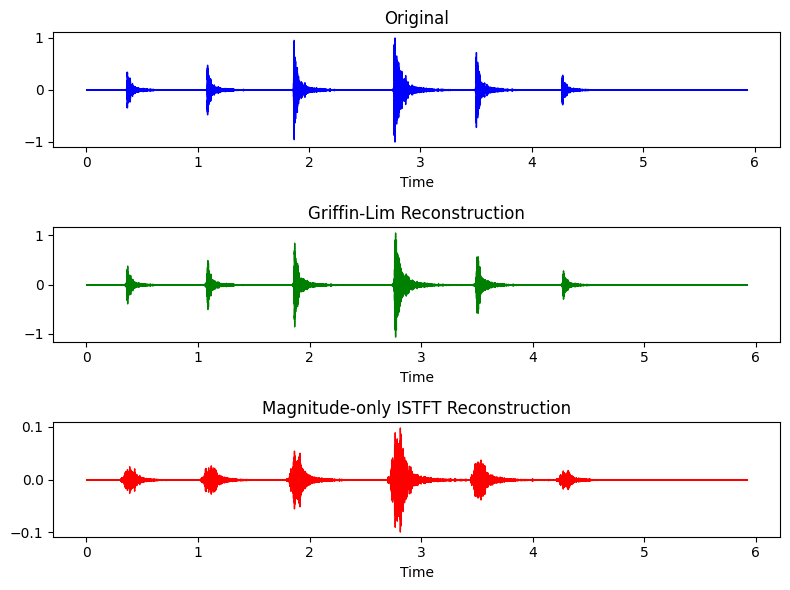

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


# Load the original audio file
y, sr = librosa.load('G:/UTS/2024/Spring_2024/Advance Data Algorithm and Machine Learning/DataGeneration-VAE/Instrument Sound Generation/samples/original/0.wav')

# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Separate magnitude and phase
magnitude, phase = np.abs(D), np.angle(D)

# Perform Griffin-Lim reconstruction (estimating phase)
y_griffinlim = librosa.griffinlim(magnitude)

# Perform magnitude-only ISTFT reconstruction (without phase)
y_istft = librosa.istft(magnitude)

# Plotting the waveforms
plt.figure(figsize=(8, 6))

# Plot Original waveform
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr, color='blue')
plt.title("Original")

# Plot Griffin-Lim reconstructed waveform
plt.subplot(3, 1, 2)
librosa.display.waveshow(y_griffinlim, sr=sr, color='green')
plt.title("Griffin-Lim Reconstruction")

# Plot magnitude-only ISTFT reconstruction waveform
plt.subplot(3, 1, 3)
librosa.display.waveshow(y_istft, sr=sr, color='red')
plt.title("Magnitude-only ISTFT Reconstruction")

plt.tight_layout()
plt.show()
